In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# List all files including hidden ones and with their file types
!ls -lha '/content/drive/My Drive/UofT/Course/4th year/aps360/'


ls: cannot access '/content/drive/My Drive/UofT/Course/4th year/aps360/': No such file or directory


In [ ]:
import zipfile
import os

# Path to the zip file
zip_path = '/content/drive/My Drive/APS360 Group Project/small_dataset_cleaned.zip'

# Destination folder for unzipped files
extract_dir = '/content/dataset'
os.makedirs(extract_dir, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Labels extracted to: {extract_dir}")


Labels extracted to: /content/dataset


In [ ]:
# List the files in the extracted directory
!ls /content/dataset/images/test/18a920aa32



0d5604e63b.jpg	2b4e72cc94.jpg	9edfbce4bf.jpg	cd047c4783.jpg	e144e5f493.jpg
1a1dd4c33f.jpg	4d64968caf.jpg	aae10afad8.jpg	d389e1c3bc.jpg	e7ae27c207.jpg
225076bc5c.jpg	58d493a3c8.jpg	ba1113bc22.jpg	d901eede31.jpg	f2645c0e00.jpg
27eb456846.jpg	779d05b752.jpg	c07d951104.jpg	d9ec847c49.jpg	f6af694f58.jpg


In [ ]:
# Path to the list_ingredients.txt file
# ingredient_list_path = '/content/drive/My Drive/UofT/Course/4th year/aps360/list_ingredients.txt'
ingredient_list_path = '/content/drive/My Drive/list_ingredients.txt'
# Reading the ingredients from the file, stopping when 'Top 10' is encountered
ingredients = []
with open(ingredient_list_path, 'r') as f:
    for line in f:
        # Stop reading if we encounter the 'Top 10 Most Common Ingredients' line
        if line.startswith('Top'):
            break

        # Skip lines that are not ingredients or are headers
        if ':' in line or line.strip() == '':
            continue

        # Extract the ingredient name before the '(' character (ignore the numbers)
        ingredient = line.split('(')[0].strip()
        ingredients.append(ingredient)

# Check how many ingredients were read and print a few for verification
print(f"Total ingredients: {len(ingredients)}")
print(ingredients[:10])  # Display the first 10 ingredients for verification

# Create a dictionary mapping each ingredient to a unique index
ingredient_dict = {ingredient: i for i, ingredient in enumerate(ingredients)}
print(f"Total unique ingredients mapped: {len(ingredient_dict)}")
print(list(ingredient_dict.items())[:10])  # Display first 10 mappings for verification


Total ingredients: 345
['adzuki beans', 'all purpose cajun seasoning', 'almond milk beverages', 'almonds', 'ancho peppers', 'anise seed', 'apples', 'apricot jams and preserves', 'artichokes', 'arugula']
Total unique ingredients mapped: 345
[('adzuki beans', 0), ('all purpose cajun seasoning', 1), ('almond milk beverages', 2), ('almonds', 3), ('ancho peppers', 4), ('anise seed', 5), ('apples', 6), ('apricot jams and preserves', 7), ('artichokes', 8), ('arugula', 9)]


In [ ]:
import os
import glob
import random
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class IngredientDataset(Dataset):
    def __init__(self, image_folder, label_folder, ingredient_dict, transform=None, folder_percentage=1.0, image_percentage=1.0):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
        self.ingredient_dict = ingredient_dict
        self.data = []

        # Collect all key names (subfolders in image_folder for train/val/test)
        all_folders = [key_name for key_name in os.listdir(label_folder) if key_name.endswith('.txt')]

        # Sample a subset of folders based on the folder_percentage
        folder_count = int(len(all_folders) * folder_percentage)
        selected_folders = random.sample(all_folders, folder_count)

        for key_name in selected_folders:
            key_name_no_ext = key_name.replace('.txt', '')
            image_dir = os.path.join(image_folder, key_name_no_ext)
            label_file = os.path.join(label_folder, key_name)

            # Check if the image folder and label file both exist
            if not os.path.exists(image_dir):
                print(f"Missing image folder for key: {key_name_no_ext}")
                continue

            if not os.path.exists(label_file):
                print(f"Missing label file for key: {key_name_no_ext}")
                continue

            # Collect all images in the key_name subfolder
            images = glob.glob(os.path.join(image_dir, "*.jpg"))

            # Sample a subset of images within the folder based on image_percentage
            image_count = int(len(images) * image_percentage)
            selected_images = random.sample(images, image_count) if image_count < len(images) else images

            if selected_images:
                self.data.append((key_name_no_ext, selected_images, label_file))
            else:
                print(f"No images found in folder for key: {key_name_no_ext}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        key_name, image_paths, label_path = self.data[idx]

        # Load and transform all images in the folder
        images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
        if self.transform:
            images = [self.transform(img) for img in images]

        # Stack images into a single tensor with shape (num_images, channels, height, width)
        images_tensor = torch.stack(images)

        # Load and encode the label
        with open(label_path, 'r') as f:
            ingredients = f.read().strip().split('\n')
        label_tensor = torch.tensor(self._encode_ingredients(ingredients), dtype=torch.float)

        return key_name, images_tensor, label_tensor

    def _encode_ingredients(self, ingredients):
        # Convert list of ingredients to a one-hot vector
        ingredient_vector = [0] * len(self.ingredient_dict)
        for ingredient in ingredients:
            if ingredient in self.ingredient_dict:
                ingredient_vector[self.ingredient_dict[ingredient]] = 1
        return ingredient_vector

# Define image transformations (resize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Set the desired percentage of folders and images to use
folder_percentage_train = 0.1  # Use 50% of folders for training
image_percentage_train = 1   # Use 50% of images per folder

folder_percentage_val = 0.1    # Use 30% of folders for validation
image_percentage_val = 1   # Use 50% of images per folder

folder_percentage_test = 0.1   # Use 30% of folders for testing
image_percentage_test = 1   # Use 50% of images per folder

# Paths to train image and label folders
train_image_folder = '/content/dataset/images/train'
train_label_folder = '/content/dataset/labels/train'
val_image_folder = '/content/dataset/images/val'
val_label_folder = '/content/dataset/labels/val'
test_image_folder = '/content/dataset/images/test'
test_label_folder = '/content/dataset/labels/test'

# Initialize dataset and DataLoader with percentages
train_dataset = IngredientDataset(train_image_folder, train_label_folder, ingredient_dict, transform=transform,
                                  folder_percentage=folder_percentage_train, image_percentage=image_percentage_train)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

val_dataset = IngredientDataset(val_image_folder, val_label_folder, ingredient_dict, transform=transform,
                                folder_percentage=folder_percentage_val, image_percentage=image_percentage_val)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

test_dataset = IngredientDataset(test_image_folder, test_label_folder, ingredient_dict, transform=transform,
                                 folder_percentage=folder_percentage_test, image_percentage=image_percentage_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Verify that the subsets are loaded correctly
for i in range(len(test_loader)):
    key_name, images, labels = train_dataset[i]
    print(f"Key Name: {key_name}")
    print(f"Number of images in sample: {images.shape[0]}")
    print(f"Image tensor shape (per image): {images.shape[1:]}")
    print(f"Label (One-hot encoded): {labels}")
    break


Key Name: 04283b616b
Number of images in sample: 14
Image tensor shape (per image): torch.Size([3, 224, 224])
Label (One-hot encoded): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0

In [ ]:
import pandas as pd
# Function to generate a summary of the dataset
def generate_dataset_summary(dataset):
    data_summary = []

    # Iterate over each entry in the dataset
    for key_name, image_paths, label_file in dataset.data:
        # Add summary info for each folder
        data_summary.append({
            'Key Name': key_name,
            'Total Images in Folder': len(image_paths),
            'Label File': label_file
        })

    # Convert to DataFrame and add a total row
    data_summary_df = pd.DataFrame(data_summary)
    total_images = data_summary_df['Total Images in Folder'].sum()
    total_folders = len(data_summary_df)
    summary_row = pd.DataFrame([{'Key Name': 'Total', 'Total Images in Folder': total_images, 'Label File': f'{total_folders} Folders'}])
    data_summary_df = pd.concat([data_summary_df, summary_row], ignore_index=True)

    return data_summary_df

# Generate and display the dataset summary
train_data_summary = generate_dataset_summary(test_dataset)
# Display summaries directly with pandas
print("Train Dataset Summary")
print(train_data_summary)


Train Dataset Summary
      Key Name  Total Images in Folder  \
0   10365f7f2d                      11   
1   15b94ae004                       5   
2   039651a671                       3   
3   0225ff9fff                      17   
4   13dcfeb428                       5   
..         ...                     ...   
71  00bb62aaad                      14   
72  05543e41be                      19   
73  152adc3be9                       5   
74  172ff02a0c                       7   
75       Total                    1088   

                                     Label File  
0   /content/dataset/labels/test/10365f7f2d.txt  
1   /content/dataset/labels/test/15b94ae004.txt  
2   /content/dataset/labels/test/039651a671.txt  
3   /content/dataset/labels/test/0225ff9fff.txt  
4   /content/dataset/labels/test/13dcfeb428.txt  
..                                          ...  
71  /content/dataset/labels/test/00bb62aaad.txt  
72  /content/dataset/labels/test/05543e41be.txt  
73  /content/dataset/la

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class IngredientDetectionModel(nn.Module):
    def __init__(self, cnn_arch='resnet50', rnn_type='gru', hidden_size=512, output_size=100, num_layers=2):
        super(IngredientDetectionModel, self).__init__()

        self.name = "PR_model" #Arthur added this

        # CNN Model
        if cnn_arch == 'resnet50':
            self.cnn = models.resnet50(pretrained=True)
            self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # Removing the classification layer
            cnn_output_size = 2048  # ResNet50 output size
        elif cnn_arch == 'vgg16':
            self.cnn = models.vgg16(pretrained=True).features
            cnn_output_size = 4096  # VGG16 output size after flattening

        # RNN Model
        self.rnn_type = rnn_type
        if rnn_type == 'gru':
            self.rnn = nn.GRU(cnn_output_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(cnn_output_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Fully connected layer to map to ingredient space
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Bi-directional RNN doubles the hidden size

    def forward(self, images):
        # Process each image in the batch individually
        cnn_features = []
        for img in images:  # images is expected to be a list of image tensors for each sample
            img_features = self.cnn(img)  # Pass through CNN
            img_features = img_features.view(img_features.size(0), -1)  # Flatten CNN output
            cnn_features.append(img_features)

        # Stack all CNN features along the sequence dimension
        cnn_features = torch.stack(cnn_features, dim=1)  # Shape: (batch_size, num_images, cnn_output_size)

        # Pass stacked CNN features through RNN
        if self.rnn_type == 'gru':
            rnn_out, _ = self.rnn(cnn_features)
        elif self.rnn_type == 'lstm':
            rnn_out, (h_n, c_n) = self.rnn(cnn_features)

        # Final fully connected layer on the last RNN output
        output = self.fc(rnn_out[:, -1, :])  # Shape: (batch_size, output_size)

        return output


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Instantiate the model with the number of ingredients in the output layer
model = IngredientDetectionModel(output_size=len(ingredient_dict))  # len(ingredient_dict) = number of ingredients
criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


In [ ]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Using device: cuda
Epoch [1/10], Train Loss: 0.0947
Epoch [1/10], Validation Loss: 0.2353, Precision: 0.0135, Recall: 0.0167, F1 Score: 0.0057
Epoch [2/10], Train Loss: 0.0786
Epoch [2/10], Validation Loss: 0.2576, Precision: 0.1502, Recall: 0.0795, F1 Score: 0.0670
Epoch [3/10], Train Loss: 0.0721
Epoch [3/10], Validation Loss: 0.6629, Precision: 0.0515, Recall: 0.3531, F1 Score: 0.0321
Epoch [4/10], Train Loss: 0.0756
Epoch [4/10], Validation Loss: 0.1877, Precision: 0.0621, Recall: 0.0741, F1 Score: 0.0534
Epoch [5/10], Train Loss: 0.0699
Epoch [5/10], Validation Loss: 0.3031, Precision: 0.1725, Recall: 0.1585, F1 Score: 0.0607
Epoch [6/10], Train Loss: 0.0671
Epoch [6/10], Validation Loss: 0.3693, Precision: 0.0380, Recall: 0.2371, F1 Score: 0.0247
Epoch [7/10], Train Loss: 0.0669
Epoch [7/10], Validation Loss: 0.2734, Precision: 0.1834, Recall: 0.1817, F1 Score: 0.1039
Epoch [8/10], Train Loss: 0.0725
Epoch [8/10], Validation Loss: 0.3327, Precision: 0.0540, Recall: 0.0862, F1 Sco

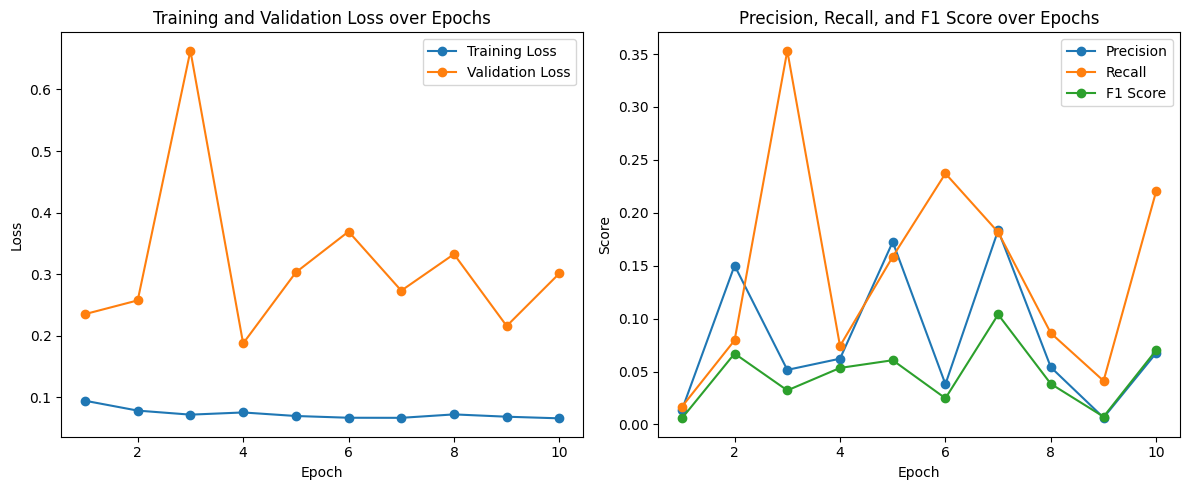

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = IngredientDetectionModel(output_size=len(ingredient_dict)).to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Custom function to calculate precision, recall, and F1-score
def calculate_f1_score(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1), axis=1)
    false_positives = np.sum((y_true == 0) & (y_pred == 1), axis=1)
    false_negatives = np.sum((y_true == 1) & (y_pred == 0), axis=1)

    # Avoid division by zero
    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = true_positives / (true_positives + false_negatives + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

    # Average across samples
    return np.mean(precision), np.mean(recall), np.mean(f1)

# Training loop with CUDA support
num_epochs = 10  # Set the number of epochs

# Lists to store metrics for plotting
train_losses = []
val_losses = []
precisions = []
recalls = []
f1_scores = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    total_batches = len(train_loader)  # Total number of batches in an epoch

    # Training phase
    for batch_idx, (key_name, images, labels) in enumerate(train_loader):
        # Move images and labels to the GPU
        images = [img.to(device) for img in images]
        labels = labels.to(device)

        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        outputs = model(images)
        outputs = outputs.sum(dim=0, keepdim=True)  # Sum across images to get shape [1, output_size]

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        train_loss += loss.item()

    # Average training loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_outputs = []

    with torch.no_grad():
        for key_name, images, labels in val_loader:
            # Move images and labels to the GPU
            images = [img.to(device) for img in images]
            labels = labels.to(device)

            # Forward pass and sum the outputs
            outputs = model(images)
            outputs = outputs.sum(dim=0, keepdim=True)  # Shape [1, output_size]

            # Calculate loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Apply sigmoid and threshold to get predictions
            probabilities = torch.sigmoid(outputs)
            predicted_ingredients = (probabilities > 0.5).int()

            # Collect true and predicted labels for metric calculation
            all_val_labels.append(labels.cpu().numpy())
            all_val_outputs.append(predicted_ingredients.cpu().numpy())

    # Average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Calculate precision, recall, and F1-score
    all_val_labels = np.vstack(all_val_labels)
    all_val_outputs = np.vstack(all_val_outputs)
    precision, recall, val_f1 = calculate_f1_score(all_val_labels, all_val_outputs)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(val_f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {val_f1:.4f}")

# Plotting the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()

# Plot Precision, Recall, and F1 Score
plt.subplot(1, 2, 2)
plt.plot(epochs, precisions, label="Precision", marker='o')
plt.plot(epochs, recalls, label="Recall", marker='o')
plt.plot(epochs, f1_scores, label="F1 Score", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def get_model_name(name, batch_size, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_epoch{2}".format(name,
                                                   batch_size,
                                                   epoch)
    return path


In [ ]:
# Save the model
model_path = "ingredient_detection_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to ingredient_detection_model.pth


In [ ]:
# Reinitialize the model structure and load the saved weights
model = IngredientDetectionModel(output_size=len(ingredient_dict))
model.load_state_dict(torch.load(model_path))
model.to(device)
print("Model loaded and ready for testing")


<ipython-input-15-0283f65ea5bd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded and ready for testing


In [ ]:
import torch
import numpy as np

def test_model(model, test_loader, device):
    model.eval()

    all_test_labels = []
    all_test_outputs = []

    with torch.no_grad():
        for key_name, images, label in test_loader:
            # Move label to device and ensure it has the correct shape
            label = label.to(device).squeeze(0)

            # Process all images in the folder by summing their predictions
            images = [img.to(device) for img in images]  # List of images
            outputs = model(images)  # Pass list of images through the model
            outputs = outputs.sum(dim=0, keepdim=True)  # Sum predictions to get shape [1, output_size]

            # Apply sigmoid and threshold to get predictions
            probabilities = torch.sigmoid(outputs).squeeze(0)  # Shape: (output_size,)
            predicted_ingredients = (probabilities > 0.5).int()  # Binary predictions

            # Debugging: print shapes for verification
            print(f"Folder '{key_name[0]}': label shape: {label.shape}, prediction shape: {predicted_ingredients.shape}")

            # Append label and prediction for each folder
            all_test_labels.append(label.cpu().numpy())
            all_test_outputs.append(predicted_ingredients.cpu().numpy())

    # Convert lists to numpy arrays for metric calculation
    all_test_labels = np.array(all_test_labels)
    all_test_outputs = np.array(all_test_outputs)

    # Calculate precision, recall, and F1-score
    precision, recall, f1_score = calculate_f1_score(all_test_labels, all_test_outputs)

    print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1 Score: {f1_score:.4f}")
    return {"precision": precision, "recall": recall, "f1_score": f1_score}

# Example usage
test_metrics = test_model(model, test_loader, device)


Folder '12d2ade4d7': label shape: torch.Size([345]), prediction shape: torch.Size([345])
Folder '0402f234f9': label shape: torch.Size([345]), prediction shape: torch.Size([345])
Folder '04684b0f2a': label shape: torch.Size([345]), prediction shape: torch.Size([345])
Folder '12339384ad': label shape: torch.Size([345]), prediction shape: torch.Size([345])
Folder '0f04c8e3ab': label shape: torch.Size([345]), prediction shape: torch.Size([345])
Folder '1372a8d2f9': label shape: torch.Size([345]), prediction shape: torch.Size([345])
Folder '147adcc2bd': label shape: torch.Size([345]), prediction shape: torch.Size([345])
Folder '174d7d5a8e': label shape: torch.Size([345]), prediction shape: torch.Size([345])
Folder '171ebed65e': label shape: torch.Size([345]), prediction shape: torch.Size([345])
Folder '172472f558': label shape: torch.Size([345]), prediction shape: torch.Size([345])
Folder '0f26302a2d': label shape: torch.Size([345]), prediction shape: torch.Size([345])
Folder '0772646fd3': 